In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML

import os, typing

/var/folders/qh/wybqz5g16cl72p8y8_w08npr0000gn/T/ipykernel_5591/2316066212.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [43]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
    """
    Plots the training history of multiple models on the same plot for comparison.
    
    Parameters:
      histories: List of History objects from multiple model's fit() calls.
      metric: The metric to plot ('loss', 'accuracy', etc.).
      labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
    """
    # Check if labels are provided, otherwise generate default labels
    # if labels is None:
    #   labels = [f'Model {i+1}' for i in range(len(histories))]

    # Initialize the plot
    plt.figure(figsize=(10, 6))

    norm = plt.Normalize(vmin=0, vmax=len(histories))
    grayscale_cmap = plt.colormaps['gray']

    sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
    for i, label in enumerate(sorted_keys):
        history = histories[label]
        #for i, (label, history) in enumerate(histories.items()):
        epochs = range(1, len(history.history[metric]) + 1)

        # Plot training metric
        plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))

        # Plot validation metric if available
        if show_validation and f'val_{metric}' in history.history:
            plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))

    # Add labels and title
    plt.title(f'Comparison of {metric.capitalize()} Between Models')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    # Show plot
    plt.show()


In [6]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 100
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

### Read the data

Download the 2 heartbeat data files from
https://www.kaggle.com/shayanfazeli/heartbeat

You can also get the files from my Google Drive:

[ptbdb_abnormal.csv](https://drive.google.com/file/d/1Kuvc_WmjLhz1xaSvL-bu94i8dEU4JMws/view?usp=sharing)

[ptbdb_normal.csv](https://drive.google.com/file/d/1L0qVW-xTGcaEgS4NdY6ZhzEEWTqMTQCH/view?usp=sharing)

In [8]:
data_dir = "../../datasets/ekg-data"
df_normal = pd.read_csv(os.path.join(data_dir, "ptbdb_normal.csv.zip"),   header=None)
df_abnormal = pd.read_csv(os.path.join(data_dir, "ptbdb_abnormal.csv.zip"), header=None)

In [9]:
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


In [10]:
df_normal.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,0.106564,0.106969,0.115883,0.122366,0.122366,0.119530,0.115883,0.122366,0.126013,0.133712,0.134927,0.142626,0.151135,0.158428,0.163695,0.173825,0.188817,0.207861,0.230956,0.258509,0.294571,0.325770,0.362642,0.398298,0.429498,0.449352,0.450972,0.418963,0.372771,0.310373,0.250000,0.204214,0.168963,0.147488,0.130470,0.124392,0.117504,0.116694,0.115883,0.118720,0.115478,0.113857,0.119530,0.116694,0.122771,0.120746,0.116694,0.122771,0.126418,0.131686,0.141815,0.139384,0.145057,0.143436,0.141005,0.140600,0.138169,0.136953,0.132091,0.128444,0.128444,0.128039,0.125203,0.122366,0.117099,0.112642,0.113047,0.127634,0.165316,0.179498,0.161264,0.176661,0.182739,0.174635,0.151540,0.147893,0.134927,0.122771,0.106969,0.098055,0.094408,0.089141,0.089141,0.088736,0.090762,0.085900,0.085900,0.089141,0.084279,0.057942,0.000000,0.116288,0.309562,0.834279,0.964344,0.561588,0.081442,0.032415,0.112642,0.152350,0.135737,0.124797,0.123582,0.123582,0.115883,0.115478,0.116694,0.124797,0.128039,0.130065,0.126823,0.129660,0.136143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,0.361781,0.362400,0.366110,0.367965,0.374150,0.377860,0.382189,0.384663,0.398887,0.401361,0.418058,0.443414,0.457638,0.487941,0.520717,0.559678,0.604205,0.634508,0.653680,0.672851,0.678417,0.660482,0.621521,0.555968,0.482375,0.438466,0.378479,0.351268,0.319728,0.306741,0.295609,0.293135,0.291899,0.292517,0.278912,0.278912,0.280767,0.280767,0.285714,0.274583,0.275201,0.273964,0.284477,0.276438,0.275201,0.277675,0.279530,0.282622,0.279530,0.273346,0.268398,0.269017,0.267780,0.257267,0.252319,0.252938,0.257267,0.249845,0.251082,0.251082,0.249845,0.241806,0.241187,0.243661,0.244898,0.239332,0.241806,0.238714,0.242424,0.241187,0.230674,0.232529,0.228200,0.237477,0.243043,0.243661,0.243043,0.269017,0.263451,0.290662,0.276438,0.278293,0.251701,0.256648,0.252319,0.246135,0.246753,0.238095,0.220779,0.230674,0.235622,0.246135,0.244280,0.250464,0.258503,0.256030,0.346939,0.416821,0.517007,0.869511,0.984539,0.555349,0.241806,0.030921,0.044527,0.227582,0.268398,0.281385,0.316636,0.325912,0.331478,0.339518,0.348794,0.346939,0.344465,0.350031,0.359307,0.366729,0.376623,0.385900,0.397650,0.416821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,0.077342,0.087223,0.091993,0.095060,0.096422,0.104940,0.108007,0.113799,0.116525,0.119932,0.124361,0.132198

### Read the data

In [11]:
X_normal   = df_normal.values
X_abnormal = df_abnormal.values

In [12]:
print(X_normal.shape)
print(X_abnormal.shape)

(4046, 188)
(10506, 188)


### Problem 1.  Plot a randomly-chosen normal segment, and abnormal segment

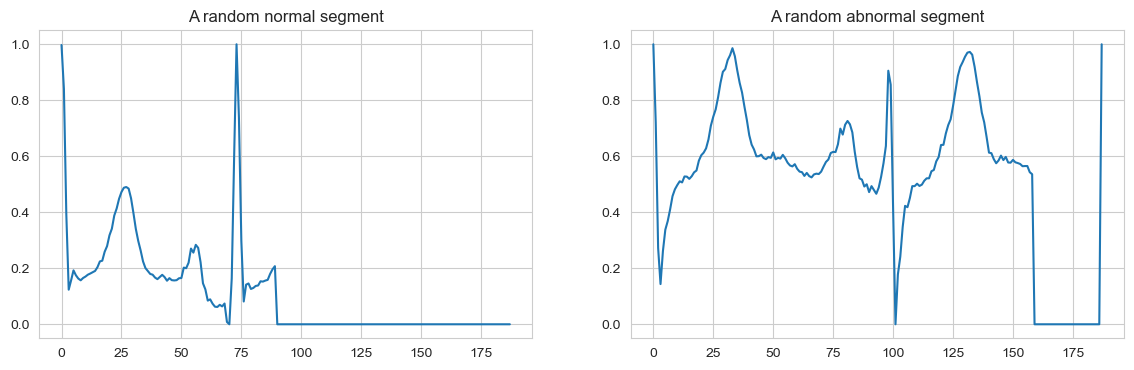

In [14]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

i = np.random.choice(X_normal.shape[0])
axs[0].plot(X_normal[i])
axs[0].set_title('A random normal segment')

i = np.random.choice(X_abnormal.shape[0])
axs[1].plot(X_abnormal[i])
axs[1].set_title('A random abnormal segment');

### Data preprocessing

Please read the code carefully

In [15]:
X = np.concatenate([X_normal, X_abnormal])

In [16]:
X.shape

(14552, 188)

In [17]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [18]:
X.shape

(14552, 188, 1)

In [19]:
y = np.concatenate([np.full(X_normal.shape[0], 0), np.full(X_abnormal.shape[0], 1)])

In [20]:
y.shape

(14552,)

### Train/test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9749, 188, 1) (9749,)
(4803, 188, 1) (4803,)


### Problem 2. Create at least two 1D convolutional models.

Try playing with the following things:
- use of global max pooling (vs. avg)
- use of an additional dense layer
- number of output channels
- size of the convolutional filters
- pooling size

If you find that you get very high accuracy, try making the validation split in your fit() call much larger.

### Model 1

In [23]:
K.clear_session()

In [24]:
num_output_channels = 16
conv_size = 3
pooling_size = 2
output_size = 48
act_fun = 'relu'
    
model = models.Sequential()
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun, input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pooling_size))
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(output_size, activation=act_fun))
model.add(layers.Dense(1, activation='sigmoid'))

/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-04 10:35:02.337663: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-11-04 10:35:02.337723: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-04 10:35:02.337737: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-04 10:35:02.337767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-04 10:35:02.337789: I tensorflow/core/common_runtime/pluggable_device/pluggable_

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 186, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 91, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,713 (6.69 KB)

 Trainable params: 1,713 (6.69 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(X_train, y_train, batch_size=16, epochs=5, validation_split=0.8)

Epoch 1/5


2024-11-04 10:35:23.935900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7151 - loss: 0.5817 - val_accuracy: 0.7224 - val_loss: 0.4780
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7440 - loss: 0.4205 - val_accuracy: 0.9799 - val_loss: 0.1838
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9942 - loss: 0.1124 - val_accuracy: 0.9991 - val_loss: 0.0181
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9997 - loss: 0.0110 - val_accuracy: 0.9991 - val_loss: 0.0067
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9990 - loss: 0.0076 - val_accuracy: 0.9991 - val_loss: 0.0058


In [28]:
y_pred = model.predict(X_test).flatten().round().astype(int)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [29]:
print(f'test accuracy: {(y_pred == y_test).mean():.3f}')

test accuracy: 0.999


### Model 2

In [34]:
K.clear_session()

In [35]:
num_output_channels = 16
conv_size = 3
pooling_size = 2
output_size = 48
act_fun = 'relu'

model = models.Sequential()
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun, input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pooling_size))
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun))
model.add(layers.MaxPooling1D(pooling_size))
model.add(layers.Flatten())
model.add(layers.Dense(output_size, activation=act_fun))
model.add(layers.Dense(1, activation='sigmoid'))

/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 186, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 91, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        34,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,505 (138.69 KB)

 Trainable params: 35,505 (138.69 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(X_train, y_train, batch_size=16, epochs=5, validation_split=0.8)

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7381 - loss: 0.5541 - val_accuracy: 0.7878 - val_loss: 0.4436
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7914 - loss: 0.4438 - val_accuracy: 0.7835 - val_loss: 0.4454
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7876 - loss: 0.4216 - val_accuracy: 0.7968 - val_loss: 0.3933
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8193 - loss: 0.3878 - val_accuracy: 0.8186 - val_loss: 0.3836
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8448 - loss: 0.3477 - val_accuracy: 0.8199 - val_loss: 0.3624


In [52]:



def make_and_train(
        *,
        use_global_pooling=False,
        num_output_channels = 16,
        conv_size = 3,
        pooling_size = 2,
        output_size = 48,
        act_fun = 'relu',
        num_epochs=50
):
    
    model = models.Sequential()
    model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun, input_shape=(X_train.shape[1],1)))
    model.add(layers.MaxPooling1D(pooling_size))
    model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun))
    if use_global_pooling:
        model.add(layers.GlobalMaxPooling1D())
    else:
        model.add(layers.MaxPooling1D(pooling_size))
    model.add(layers.Flatten())
    model.add(layers.Dense(output_size, activation=act_fun))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_split=0.8)
    return history


Epoch 1/50


/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7093 - loss: 0.5531 - val_accuracy: 0.7895 - val_loss: 0.4567
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7779 - loss: 0.4479 - val_accuracy: 0.7953 - val_loss: 0.4501
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8076 - loss: 0.4122 - val_accuracy: 0.7813 - val_loss: 0.4181
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8310 - loss: 0.3627 - val_accuracy: 0.8222 - val_loss: 0.3775
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8210 - loss: 0.3856 - val_accuracy: 0.8160 - val_loss: 0.3651
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8426 - loss: 0.3499 - val_accuracy: 0.8419 - val_loss: 0.3425
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8563 - loss: 0.3360 - val_accuracy: 0.8615 - val_loss: 0.3239
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8685 - loss: 0.3013 - val_accuracy: 0.866

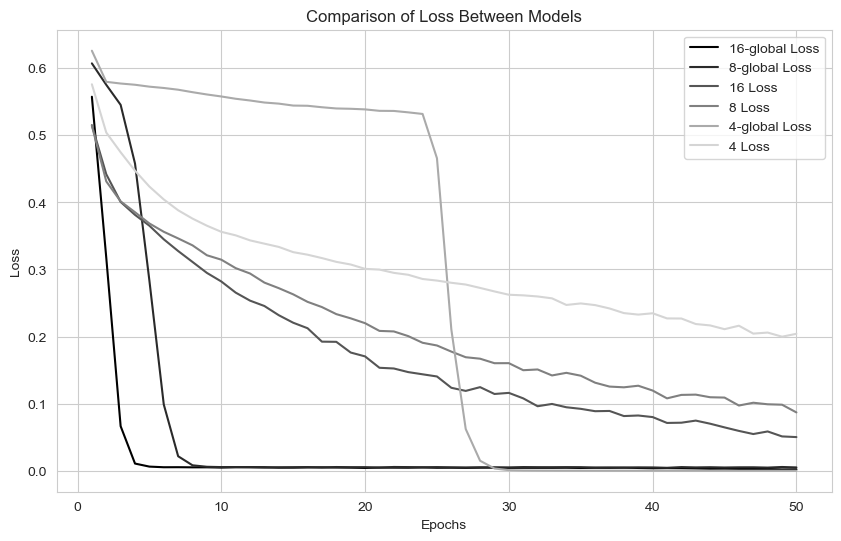

In [53]:
plot_multiple_histories({
    "16" : make_and_train(num_output_channels=16),
    "8" : make_and_train(num_output_channels=8),
    "4" : make_and_train(num_output_channels=4),
    "16-global" : make_and_train(num_output_channels=16, use_global_pooling=True),
    "8-global" : make_and_train(num_output_channels=8, use_global_pooling=True),
    "4-global" : make_and_train(num_output_channels=4, use_global_pooling=True),
})